### Forecasting using Gradient Boosted Trees

In this notebook I will now dive in Machine learning model namely Gradient Boosted Trees using lightgbm library. Time series forecasting using machine learning models is done by treating the problem as supervised learning regression problem and thus I will first create autoregressive, autoregressive lag error and moving average features.

In [1]:
#loading libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor

In [2]:
#loading data
df = pd.read_csv('air_pollution.csv')

In [3]:
#converting to datetime
df['date'] = pd.to_datetime(df['date'])

In [4]:
# scaler = MinMaxScaler()


# for column in df.columns[1:]:
    
#     df[column] = scaler.fit_transform(df[[column]])

In [5]:
#melting the dataframe so that each row consists data for specific pollutant as seen below
df = pd.melt(df, id_vars='date', value_vars=df.columns[1:]).reset_index(drop=True)

#renaming columns
df.columns = ['date','pollutant','quantity']

#sorting based on date and pollutant
df = df.sort_values(['date','pollutant']).reset_index(drop=True)

df.head()

,date,pollutant,quantity
0,2004-02-15,CO,1.068245
1,2004-02-15,NO_2,79.180782
2,2004-02-15,O_3,12.400776
3,2004-02-15,PM10,51.815004
4,2004-02-15,PM25,27.801169


In [6]:
#this function creates lag features
def create_lag(df,number_of_lags):
    
    #using the input number of lags, lag features will be created starting from lag of 1 to number_of_week lags
    for lag in range(1,number_of_lags+1):
        
        column_name = 'lag_'+str(lag)
        df[column_name] = df.groupby(['pollutant'])['quantity'].shift(lag)
        
    return df

In [7]:
#this function creates lag residuals/erros
def create_lag_errors(df,number_of_lags):
    
    #using the input number of lags, lag residual features will be created starting from lag of 1 to number_of_week lags
    for lag in range(2,number_of_lags+1):
        
        column_name = 'lag_errors_'+str(lag)
        
        df[column_name] = df.groupby(['pollutant'])['quantity'].shift(lag-1) - df.groupby(['pollutant'])['quantity'].shift(lag)
        
    return df

In [8]:
#this function creates moving average features
def create_moving_average(df,moving_weeks):
    
    #using input moving_weeks, moving averages for the specified number of weeks created
    for moving_week in moving_weeks:
        
        column_name = 'moving_avg_' + str(moving_week)
        
        df[column_name] = df.groupby(['pollutant'])['quantity'].transform(lambda x: x.rolling(moving_week).mean())
        
    return df

In [9]:
#this functions calls the above functions to create the features
def create_features(df):
    
    #specifying number of lag, lag error/residuals and moving avergaes
    number_of_lags = 52
    moving_weeks = [4,8,12]
    
    #categorical features
    df['week_of_year'] = df['date'].dt.weekofyear.astype(int)
    df['month'] = df['date'].dt.month
    
    #numerical features
    df = create_lag(df,number_of_lags)
    df = create_lag_errors(df,number_of_lags)
    df = create_moving_average(df,moving_weeks)
    
    df = df.dropna()
    
    return df
    


In [10]:
#creating features
df = create_features(df)

In [11]:
#label encoding pollutants
print(dict(enumerate(df['pollutant'].astype('category').cat.categories)))
df['pollutant'] = df['pollutant'].astype('category').cat.codes

{0: 'CO', 1: 'NO_2', 2: 'O_3', 3: 'PM10', 4: 'PM25', 5: 'SO_2'}


In [12]:
#creating train and test dataset
train = df[df['date'].dt.year<2017]
test = df[df['date'].dt.year>=2017]

In [13]:
#creating features and target variable
X_train, X_test = train.drop(['quantity','date'],axis=1), test.drop(['quantity','date'],axis=1)
y_train, y_test = train[['quantity']], test[['quantity']]

In [14]:
X_train.head()

,pollutant,week_of_year,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_errors_46,lag_errors_47,lag_errors_48,lag_errors_49,lag_errors_50,lag_errors_51,lag_errors_52,moving_avg_4,moving_avg_8,moving_avg_12
312,0,6,2,0.755620,0.657735,1.136940,1.488046,1.204828,0.962628,0.854022,...,0.108609,-0.172014,0.073085,-0.164590,0.138457,-0.074996,-0.385295,0.875809,1.001595,0.993200
313,1,6,2,69.863716,54.835228,86.676688,108.156400,80.706603,69.754705,63.308224,...,8.071938,-13.055537,1.727996,-12.818784,14.458395,-4.763559,-19.315294,73.259999,76.870741,74.143265
314,2,6,2,23.245369,31.682712,12.762710,7.434492,11.212100,17.356486,20.416040,...,-9.208752,20.945863,-2.810988,0.059893,-1.173413,9.311536,9.355692,21.535477,17.820129,16.365192
315,3,6,2,29.961035,21.745874,42.978184,69.365529,37.720337,30.722594,23.800833,...,1.685205,-42.916534,34.462095,-11.283626,20.237257,-13.439121,-23.259497,32.944579,36.673451,36.682070
316,4,6,2,16.066019,11.924758,23.816695,41.590177,24.208014,19.728857,15.225487,...,1.771861,-14.897024,10.889825,-5.054113,8.721550,-6.864485,-9.729223,18.260107,21.724120,22.664722


In [15]:
y_train.head()

,quantity
312,0.952942
313,81.664363
314,18.451118
315,37.093223
316,21.232954


In [16]:
#defining evaluation metrics
def smape(y_true, pred):
    return 100/len(y_true) * np.sum(2 * np.abs(pred - y_true) / (np.abs(y_true) + np.abs(pred)))

def rmse(y_true,pred):
    return np.sqrt(np.mean((pred-y_true)**2))

In [17]:
#initiliazing model
model = LGBMRegressor()
#passing categorical features
categorical_columns = ['pollutant','week_of_year','month']
#fitting model
model.fit(X_train,y_train,categorical_feature =categorical_columns)
#getting predictions
predictions = model.predict(X_test)

D:\Anaconda\lib\site-packages\lightgbm\basic.py:1246: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['month', 'pollutant', 'week_of_year']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


In [18]:
print('SMAPE :' ,smape(np.array(y_test).ravel(),predictions))
print('RMSE :',rmse(np.array(y_test).ravel(),predictions))

SMAPE : 17.70019769282645
RMSE : 4.034898403323562


In [19]:
rmse(np.array(y_test).ravel(),predictions)/y_test.mean()

quantity    0.196848
dtype: float64

In [20]:
pollutants = np.array(X_test[['pollutant']]).ravel()
preds = predictions
actuals = np.array(y_test[['quantity']]).ravel()

In [21]:
forecast_data = {'pollutant':pollutants,'actual':actuals,'predictions':preds}
forecast = pd.DataFrame(forecast_data)

Original: {0: 'CO', 1: 'NO_2', 2: 'O_3', 3: 'PM10', 4: 'PM25', 5: 'SO_2'}

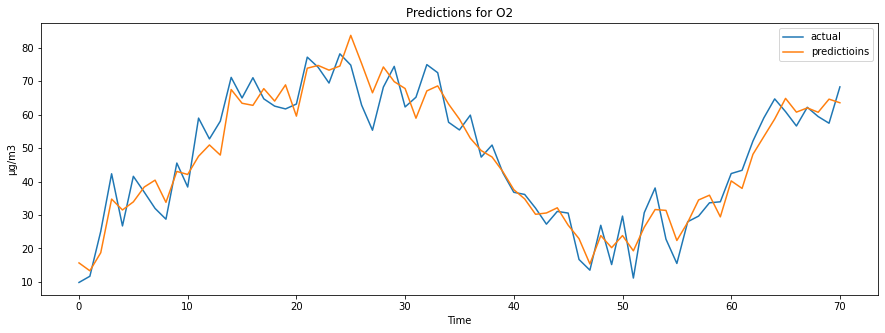

In [38]:
forecast_0 = forecast[forecast['pollutant']==2]

plt.figure(figsize=(15,5))
sns.lineplot(np.arange(0,len(forecast_0)),forecast_0['actual'])
sns.lineplot(np.arange(0,len(forecast_0)),forecast_0['predictions'])
plt.title('Predictions for O2')
plt.xlabel('Time')
plt.ylabel('μg/m3')
plt.legend(['actual','predictioins'])